<a href="https://colab.research.google.com/github/mrMichalR/Classification/blob/main/cifar10_pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an image classifier
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# 1. Load and normalize CIFAR10

The output of torchvision datasets are PILImage images of range [0, 1].

**We transform them to Tensors of normalized range [-1, 1].**

*) PIL - Python Image Librabry

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5) #torchvision.transforms.Normalize(mean, std, inplace=False) ; mean=0,5 and std=0,5 result in pixel value range 0-1 (0,5 +/-0,5)
    ])

batch_size = 2 # number of images taken at one run

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=5)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size,
                                         shuffle=False, 
                                         num_workers=5)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


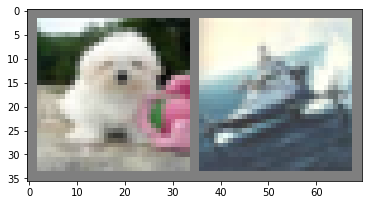

dog   ship 


In [19]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 2. Define a Convolutional Neural Network

Example of NN structure

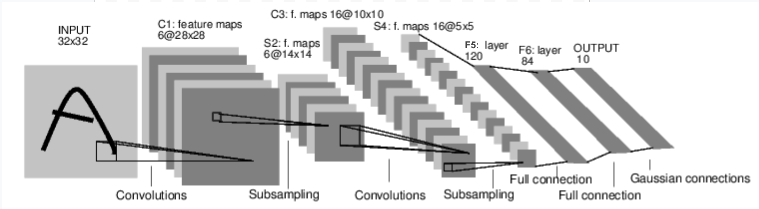

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 input image channel (RGB) size (32x32), 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5) # Conv2d(in_channels= 3 (here RGB), out_channels=6, kernel_size=5, ...)
        self.pool = nn.MaxPool2d(2, 2) # MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # Linear(in_features, out_features, bias=True, device=None, dtype=None)
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# 3. Define a Loss function and optimizer


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4. Train the network

In [17]:
epochs=2
              
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'): # loop over the dataset multiple times
# for epoch in range(int(epochs)): # loop over the dataset multiple times
    running_loss = 0.0
    # for i, data in tqdm(enumerate(trainloader, 0),total=i, desc='Training Epochs'):
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('\nFinished Training')

Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f45e6a9eca0>Exception ignored in: Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f45e6a9eca0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f45e6a9eca0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f45e6a9eca0>

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    Traceback (most recent call last):
self._shutdown_workers()    Exception ignored in: self._shutdown_workers()  File "/usr/local/lib/python3.9/dist-packages/torch/utils

[1,  2000] loss: 1.304


Training Epochs:   0%|          | 0/2 [00:16<?, ?it/s]


KeyboardInterrupt: ignored

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

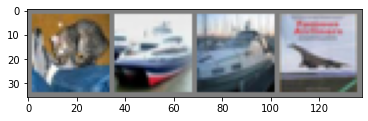

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

For education, load back in our saved model (note: saving and re-loading the model wasn’t necessary)

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
outputs = net(images)

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   plane ship  plane


In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 52 %


Check accuracy for each classes correct prediction

In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 57.2 %
Accuracy for class: car   is 65.8 %
Accuracy for class: bird  is 58.7 %
Accuracy for class: cat   is 30.6 %
Accuracy for class: deer  is 46.6 %
Accuracy for class: dog   is 53.2 %
Accuracy for class: frog  is 55.2 %
Accuracy for class: horse is 47.7 %
Accuracy for class: ship  is 69.2 %
Accuracy for class: truck is 39.6 %


# Training on GPU

Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that device is a CUDA device.

Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

In [15]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
# inputs, labels = data[0].to(device), data[1].to(device)
epochs=2
              
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[1,  2000] loss: 1.234
[1,  4000] loss: 1.225
[1,  6000] loss: 1.244
[1,  8000] loss: 1.225
[1, 10000] loss: 1.240
[1, 12000] loss: 1.240


Training Epochs:  50%|█████     | 1/2 [01:09<01:09, 70.00s/it]

[2,  2000] loss: 1.236
[2,  4000] loss: 1.237
[2,  6000] loss: 1.216
[2,  8000] loss: 1.250
[2, 10000] loss: 1.235
[2, 12000] loss: 1.230


Training Epochs: 100%|██████████| 2/2 [02:13<00:00, 66.58s/it]

Finished Training
